In [1]:
setwd("..")

In [ ]:
# uncomment to install the arcadiathemeR package, which has palettes and ggplot2 themes.
# install.packages("remotes")
# remotes::install_github("Arcadia-Science/arcadiathemeR", ref = "cd6def7caf56a528dd8207da5252964a86fd3cef")

In [2]:
library(arcadiathemeR)

Loading Suisse fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [3]:
library(tidyverse)
library(rhdf5)
library(arcadiathemeR)
library(lmerTest)
library(broom)
library(broom.mixed)
library(rstatix)
library(ggpubr)
library(ggrepel)
library(scales)
source("scripts/utils.R")

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘rstat

## Load files

In [6]:
hdf5_files <- c(Sys.glob("tierpsy_out/2024-08-19/Results/*/*featuresN.hdf5"),
                Sys.glob("tierpsy_out/2024-08-20/Results/*/*featuresN.hdf5"))

In [7]:
# 24.5*10 = 245 frames = 10 seconds of video.
# a worm must be observed for 10 seconds to be retained
timeseries <- read_timeseries_from_hdf5_files(hdf5_files, required_frames = 245)

In [8]:
timeseries <- timeseries %>%
  mutate(file_path = file_id,
         file_id = str_remove(string = basename(file_path), pattern = "_dogfilter_featuresN.hdf5"),
         strain = str_remove(string = basename(file_path), pattern = "_.*"),
         date = str_extract(string = file_path, pattern = "\\b\\d{4}-\\d{2}-\\d{2}\\b"))

## How many worms were captured on each acquisition day?

In [9]:
# count number of frames per worm
number_of_worms_captured <- timeseries %>%
  group_by(worm_index, file_id, strain, date) %>%
  tally()

nrow(number_of_worms_captured)

number_of_worms_captured %>%
  group_by(date) %>%
  tally()

number_of_worms_captured %>%
 group_by(date) %>%
 summarize(mean_frames = mean(n))

[1] 598

date,n
<chr>,<int>
2024-08-19,388
2024-08-20,210


date,mean_frames
<chr>,<dbl>
2024-08-19,557.4871
2024-08-20,501.3286


## Create motility summary

In [10]:
motility_summary <- summarize_motility_per_worm(timeseries)

## Determine which motility features are significantly different, controlling for date of acquisition

In [11]:
results <- motility_summary %>%
  # remove columns where all values are NA 
  select(-orientation_food_edge_mean, -dist_from_food_edge_mean, 
         -d_orientation_food_edge_mean, -d_dist_from_food_edge_mean,
         -food_region_mean) %>%
  # remove coord columns, which don't really make sense to compare
  select(-contains("coord")) %>%
  select(-contains("axis")) %>%
  select(-file_id, -worm_index, -timestamp_max, -timestamp_max_mean) %>%
  pivot_longer(cols = ends_with("mean"), names_to = "parameter", values_to = "value") %>%
  group_by(parameter) %>%
  nest() %>%
  mutate(models = map(data, ~lmerTest::lmer(value ~ strain + (1 | date), data = .x))) %>%
  mutate(tidy = map(models, broom.mixed::tidy)) %>%
  select(parameter, tidy) %>%
  unnest(tidy)

results_adj <- results %>%
  filter(!is.na(p.value)) %>%
  mutate(p_adj_bonferroni = p.adjust(p.value, method = "bonferroni")) %>%
  arrange(desc(term), p_adj_bonferroni) 

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [12]:
# how many parameters did we test?
length(unique(results_adj$parameter))

[1] 133

In [ ]:
write_tsv(results_adj, "2024-10-29-n2-vs-pdl1.tsv")

## Plot results from statistical tests for motility features

In [13]:
results_labeled <- read_tsv("2024-10-29-n2-vs-pdl1-figlabels.tsv", show_col_types = FALSE)

In [14]:
head(results_labeled)

measurement_type,measurement_class,body_part,parameter,effect,group,term,estimate,std.error,statistic,df,p.value,p_adj_bonferroni
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
base,speed,head,speed_head_tip_mean,fixed,NA,strainpdl-1,9.3475419,0.89028639,10.499477,576.5615,1.02e-23,2.05e-23
base,speed,head,speed_head_base_mean,fixed,NA,strainpdl-1,7.8820262,0.81996910,9.612589,576.7887,2.17e-20,4.33e-20
base,speed,neck,speed_neck_mean,fixed,NA,strainpdl-1,7.4284756,0.78742450,9.433889,576.9360,9.57e-20,1.91e-19
base,speed,midbody,speed_midbody_mean,fixed,NA,strainpdl-1,6.3794606,0.71364798,8.939226,576.9899,5.27e-18,1.05e-17
base,speed,whole_worm,speed_mean,fixed,NA,strainpdl-1,5.7995983,0.65799618,8.814030,576.7724,1.42e-17,2.84e-17
base,angular_velocity,head,relative_to_neck_angular_velocity_head_tip_mean,fixed,NA,strainpdl-1,0.1609259,0.01864215,8.632368,570.2248,6.01e-17,1.20e-16


In [15]:
results_labeled <- results_labeled %>%
  mutate(estimate_signum = ifelse(estimate > 0, "positive", "negative")) %>%
  mutate(estimate_abs = abs(estimate)) %>%
  mutate(measurement_type = str_to_sentence(measurement_type),
         measurement_class = gsub("_", " ", measurement_class),
         measurement_class = str_to_sentence(measurement_class),
         body_part = gsub("_", " ", body_part),
         body_part = str_to_sentence(body_part),
         body_part = factor(body_part, levels = c("Whole worm", "Head", "Neck", "Midbody", "Hips", "Tail")))

In [16]:
# Define the signed square root transformation so we can show negative estimates with a transformed axis
sign_sqrt_trans <- trans_new(
  name = "sign_sqrt",
  transform = function(x) sign(x) * sqrt(abs(x)),
  inverse = function(x) x * abs(x),
  domain = c(-Inf, Inf)
)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


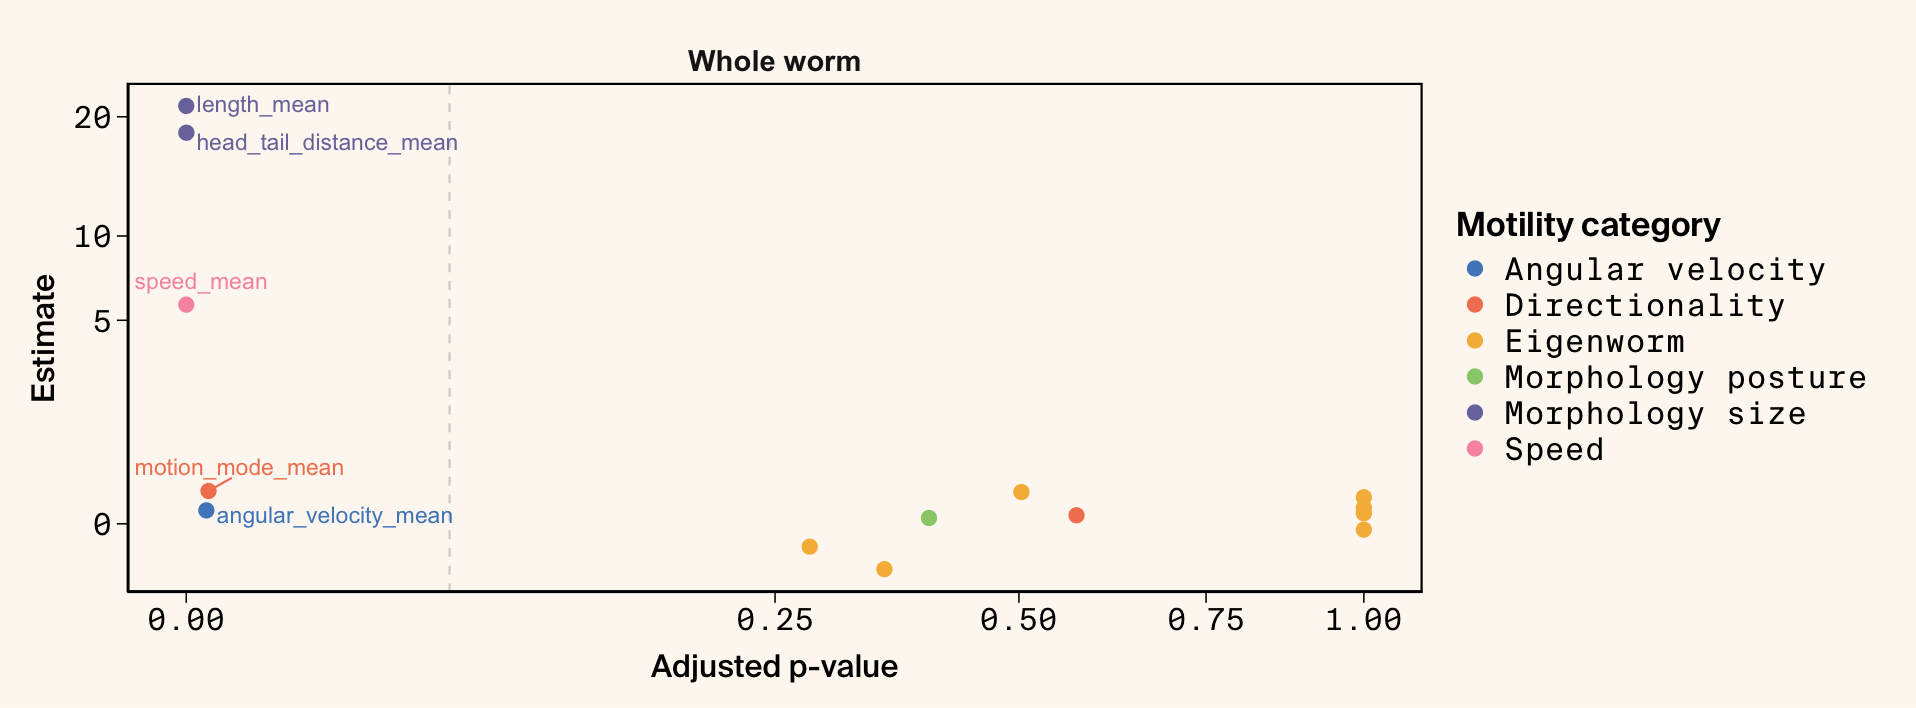

In [17]:
options(repr.plot.width = 920/72, repr.plot.height = 340/72, repr.plot.res = 150)

ggplot(results_labeled %>% 
         filter(estimate_abs < 100) %>% 
         filter(body_part == "Whole worm") %>%
         filter(measurement_type == "Base"), 
       aes(x = p_adj_bonferroni, y = estimate, color = measurement_class)) +
  geom_point(size = 3) +
  geom_vline(xintercept = 0.05, linetype = "dashed", color = "lightgrey") +
  geom_text_repel(aes(label = ifelse(p_adj_bonferroni < 0.05, parameter, "")), vjust = -1, show.legend = FALSE) +  #
  scale_color_arcadia() +
  theme_arcadia() +
  scale_y_continuous(trans = sign_sqrt_trans,     
                     breaks = c(-20, -10, -5, 0, 5, 10, 20),
                     labels = c(-20, -10, -5, 0, 5, 10, 20)) +
  scale_x_sqrt() +
  facet_wrap(~body_part, ncol = 2) +
  labs(x = "Adjusted p-value", y = "Estimate", color = "Motility category",
       shape = "Measurement type") +
  theme(panel.border = element_rect(colour = "black", fill = NA, size = 1),
        strip.text = element_text(size = 14, face = "bold")) 

## Prep for individual comparisons

prepare to plot individual statistically different parameters


In [18]:
motility_long <- motility_summary %>%
  # Remove columns where all values are NA 
  select(-orientation_food_edge_mean, -dist_from_food_edge_mean, 
         -d_orientation_food_edge_mean, -d_dist_from_food_edge_mean,
         -food_region_mean) %>%
  # Remove coordinate and axis columns
  select(-contains("coord")) %>%
  select(-contains("axis")) %>%
  # Remove other unnecessary columns
  select(-file_id, -worm_index, -timestamp_max, -timestamp_max_mean) %>%
  # Convert to long format
  pivot_longer(cols = ends_with("mean"), names_to = "parameter", values_to = "value") %>%
  # Ensure 'strain' and 'parameter' are factors
  mutate(strain = as.factor(strain),
         parameter = as.factor(parameter))

stat_test <- motility_long %>%
  group_by(parameter) %>%
  t_test(value ~ strain) %>%
  adjust_pvalue(method = "bonferroni") %>%
  add_significance()

stat_test <- stat_test %>% add_xy_position(x = "strain")

In [19]:
highlight_variables <- c("speed_mean")

In [20]:
motility_long_highlight <- motility_long %>% 
  filter(parameter %in% highlight_variables) %>%
  filter(!is.na(value))

stat_test_highlight <- stat_test %>%
  filter(parameter %in% highlight_variables) %>%
  select(-y.position)

In [21]:
y_positions_highlight <- motility_long_highlight %>%
  group_by(parameter) %>%
  summarise(max_value = max(value, na.rm = TRUE), .groups = "drop") %>% 
  mutate(y.position = max_value + max_value * 0.1)


stat_test_highlight <- stat_test_highlight %>%
  left_join(y_positions_highlight, by = c("parameter"))

In [22]:
bxp_highlight <- ggboxplot(motility_long_highlight, x = "strain", y = "value",
                           outlier.shape = "", fill = NA) +
  facet_wrap(~parameter, ncol = 3, scales = "free_y") +
  geom_jitter(color = arcadia_palette("primary")[6]) +
  stat_summary(fun = mean, geom = "point", shape = 20, size = 3, color = "black") +  # Plot mean points
  stat_summary(fun = mean, geom = "text_repel", aes(label = sprintf("%.2f", ..y..)),
               color = "black", size = 7) + 
  stat_pvalue_manual(stat_test_highlight, label = "p.adj.signif", y.position = "y.position") +
  theme_arcadia() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        strip.text = element_text(size = 14, face = "bold")) +
  labs(x = "Strain", y = "Value", color = "Date") +
  scale_color_arcadia(palette = "secondary") 


Warning message:
“The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


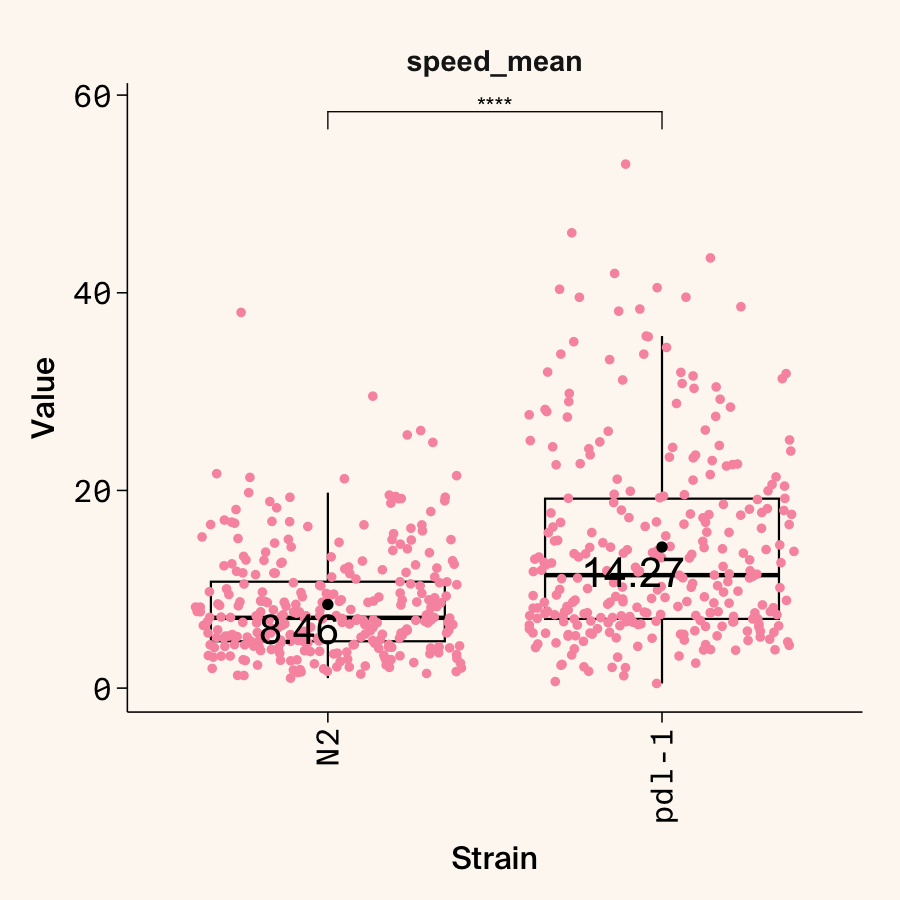

In [23]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)

bxp_highlight

## Compare against known phenotypes for pdl1

The ones we picked out overlap with motility phenotypes previously shown to be different between N2 and pdl1

In [24]:
# select specific variables to visualize
yemeni_variables <- c("motion_mode_mean", "speed_mean", "curvature_midbody_mean", "curvature_std_neck_mean",
                      "relative_to_neck_angular_velocity_head_tip_mean",
                      "relative_to_hips_angular_velocity_tail_tip_mean")

In [25]:
motility_long_yemeni <- motility_long %>% 
  filter(parameter %in% yemeni_variables) %>%
  filter(!is.na(value))

stat_test_yemeni <- stat_test %>%
  filter(parameter %in% yemeni_variables) %>%
  select(-y.position)

In [26]:
# Calculate dynamic y-positions for p-values
y_positions <- motility_long_yemeni %>%
  group_by(parameter) %>%
  summarise(max_value = max(value, na.rm = TRUE), .groups = "drop") %>% 
  mutate(y.position = max_value + max_value * 0.1)


stat_test_yemeni <- stat_test_yemeni %>%
  left_join(y_positions, by = c("parameter"))

In [27]:
bxp_yemeni <- ggboxplot(motility_long_yemeni, x = "strain", y = "value",
                        outlier.shape = "", fill = NA) +
  facet_wrap(~parameter, ncol = 3, scales = "free_y") +
  geom_jitter(alpha = 0.5, color = "#F28360") +
  stat_pvalue_manual(stat_test_yemeni, label = "p.adj.signif", y.position = "y.position") +
  theme_arcadia() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        legend.position = "bottom") +
  labs(x = "Strain", y = "Value")

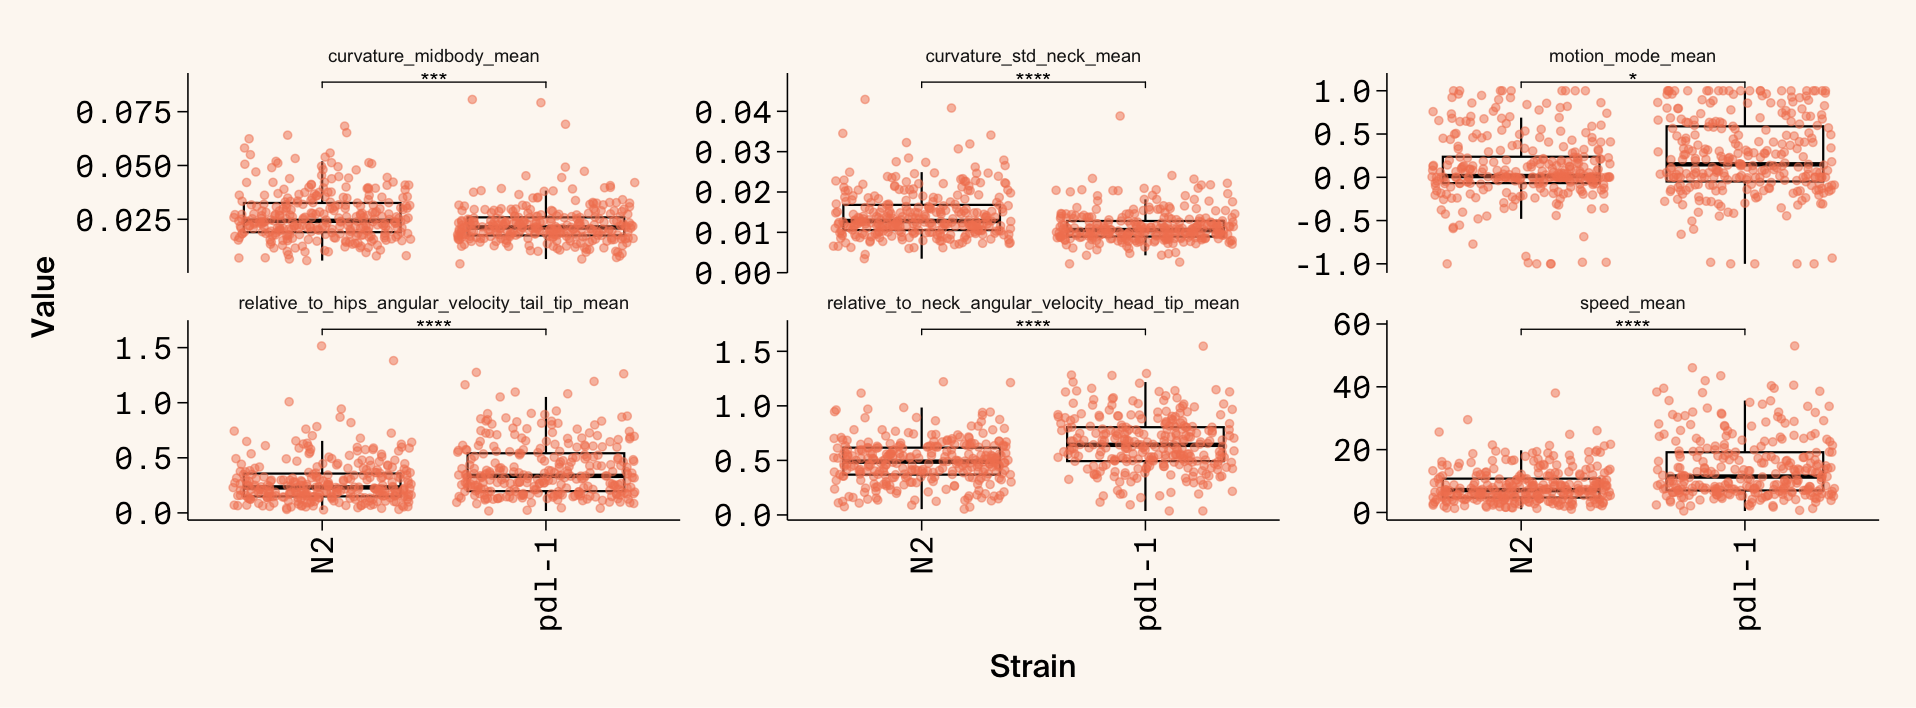

In [28]:
options(repr.plot.width = 920/72, repr.plot.height = 340/72, repr.plot.res = 150)
bxp_yemeni

In [29]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/wormmotility/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.3.0        ggrepel_0.9.5       ggpubr_0.6.0       
 [4] rstatix_0.7.2       broom.mixed_0.2.9.5 broom_1.0.6        
 [7] lmerTest_3.1-3      lme4_1.1-35.5       Matrix_1.6-5       
[10] rhdf5_2.46.1        lubridate_1.9.4     forcats_1.0.0      
[13] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.2        
[16] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[19] ggplot2_3.5.1       tidyverse_2.0.0     arcadiathemeR_0.1.0

loaded via a namespace (and n